## Load Dataset

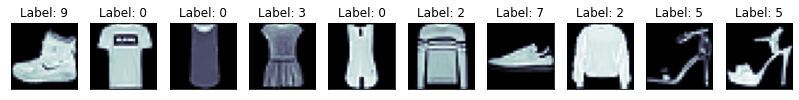

In [1]:
# Download Fashion MNIST Dataset
import gzip
import os
from urllib.request import urlretrieve
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import xlogy

def fashion_mnist():
    """
    Download compressed Fashion MNIST data to local directory, and 
    unpack data into numpy arrays. 
    
    Return (train_images, train_labels, test_images, test_labels).

    Args:
        None

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.
    """
    url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']
    path = './' # Download data to current directory.
    os.makedirs(path, exist_ok=True) # Create path if it doesn't exist.

    # Download any missing files
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url + file, os.path.join(path, file))
            print("Downloaded %s to %s" % (file, path))

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        return pixels.reshape(-1, 784).astype('float32') / 255

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)

        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        return _onehot(integer_labels)

    train_images = _images(os.path.join(path, files[0]))
    train_labels = _labels(os.path.join(path, files[1]))
    test_images = _images(os.path.join(path, files[2]))
    test_labels = _labels(os.path.join(path, files[3]))
    
    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = fashion_mnist()

# Plot examples from dataset.
plt.figure(1, figsize=(14,6))
for i in range(10):
    plt.subplot(1,10, i+1)
    plt.imshow(train_images[i,:].reshape(28,28), cmap='bone')
    plt.title(f'Label: {train_labels[i].argmax()}')
    plt.xticks([])
    plt.yticks([])

In [2]:
import timeit as t

## Implement Neural Network Class

### Gather Inputs into Neural Network

In [3]:
lr = 1e-4

# X is a (60000, 784) input where each row is a row vector sample 
X = train_images

# y is a (60000, 10) input where each row is a row vector label
y = train_labels

print(f'Shape of X is {X.shape}')
print(f'Shape of y is {y.shape}')

# 0. INITIALIZE BATCH ARRAY

batch_size = 3

# neural network parameters

input_dim, hidden_dim, output_dim = X.shape[1], 100, y.shape[1]

print(input_dim, hidden_dim, output_dim)

Shape of X is (60000, 784)
Shape of y is (60000, 10)
784 100 10


### Neural Network

We will write the necessary helper functions and the neural network class below.

In [7]:
# get all of our loss, output activation, and any other helper functions we need

def batch_crossentropy(y, y_hat):
    epsilon = 1e-4
    return -np.sum(y*np.log(y_hat + epsilon), axis=1)/y.shape[0]

def batch_softmax(x):
    li = []
    for i in range(x.shape[0]):
        exp_term = np.exp(x[i] - np.max(x))
        li.append(exp_term/np.sum(exp_term))
    return np.array(li)

def component_wise_tensor(A, B):
    tmp = []
    for i in range(len(A)):
        outer_product = np.outer(A[i], B[i])
        tmp.append(outer_product)
    C = np.array(tmp)
    return C


In [8]:
class simpleANN:
    
    # artificial 1 hidden-layer neural network whose feedforward, backpropagation are all vectorized 
    
    def __init__(self, input_dim, hidden_dim, output_dim, batch_size):
        
        # initialize weights and biases
        self.w1 = np.random.randn(input_dim, hidden_dim)
        self.b1 = np.random.randn(batch_size, hidden_dim)
        
        self.w2 = np.random.randn(hidden_dim, output_dim)
        self.b2 = np.random.randn(batch_size, output_dim)
        
        # initialize batch size as we will need to access this all throughout our code
        self.batch_size = batch_size
        
    def feedforward(self, x):
        # feedforward: perform the feeding of the input up until the output layer
        z1 = np.dot(x, self.w1) + self.b1

        # first activation (relu)
        # NOTE: normally, np.maximum(0, x) is the way to go, but since we are vectorizing, we must find a way to apply
        # relu across the whole vector
        a1 = z1

        a1[a1 < 0] = 0

        # derivative of first activation

        da_1_dz_1 = np.where(a1 > 0, 1, 0)

        # second preactivation layer

        z2 = np.dot(a1, self.w2) + self.b2
        
        return z1, a1, da_1_dz_1, z2
        
    def predict(self, x):
        # predict: this is the output layer, where we will be calling the softmax function
        return batch_softmax(x)
    
    def loss(self, y, y_hat):
        # loss: computes the cross-entropy loss 
        return batch_crossentropy(y, y_hat)
        
    def backpropagate(self, x, y, y_hat, a1, da_1_dz_1):
        # backpropagate: takes in x, y, y_hat, and the 2nd and 3rd outputs from feedforward
        dl_dz2 = y_hat - y

        # TRICKY PART: since we now have every sample's vectors, we must do
        # a component-wise outer product of each vector
        # EACH "ROW" (axis 0) OF ARRAY CORRESPONDS TO A dl/dw2 for each input/label pair
        
        dl_dw2 = np.mean(component_wise_tensor(dl_dz2, a1), axis=0).T

        # THEN TAKE THE MEAN ACROSS AXIS 0 TO GET THE UPDATED WEIGHTS, and then tranpose

        dl_dz1 = np.dot(dl_dz2, self.w2.T) * da_1_dz_1

        # elementwise tensor product, then take the mean across the axis and transpose

        dl_dw1 = np.mean(component_wise_tensor(dl_dz1, x), axis=0).T

        # get gradient of biases

        dl_db2, dl_db1 = dl_dz2, dl_dz1
        
        return dl_dw1, dl_dw2, dl_db1, dl_db2
    
    def gradient_descent(self, grad_w1, grad_w2, grad_b1, grad_b2, lr=1e-4):
        # gradient_descent: performs optimization of weights and biases
        # NOTE: changes the weights/biases in place, so returns nothing
        
        # eta is just a constant
        eta = lr/self.batch_size
        
        # actual GD steps
        self.w1, self.w2, self.b1, self.b2 = self.w1 - (eta * grad_w1), self.w2 - (eta * grad_w2), self.b1 - (eta * grad_b1), self.b2 - (eta * grad_b2)
        
        return
    
    def fit(self, x, y, max_epochs=10, lr=1e-4, x_val=None, y_val=None):
        # fit: performs training loop by calling feedforward, predict, loss, backpropagation, and gradient_descent
        # NOTE: this training is done in batches, validation inferencing at the end of each epoch is optional
        
        # array holding all batches of data
        batch_arr = [(x[k:k+self.batch_size], y[k:k+self.batch_size]) for k in range(0, x.shape[0], self.batch_size)]
        num_batches = len(batch_arr)
        
        # count total train time
        total_train_time = 0
        
        # compile a history for metrics so we can plot performance later
        history, li_trainloss, li_trainacc = dict(), [], []
        
        # training loop
        for epoch in range(max_epochs):
            epoch_correct_classes = 0
            # initialize total loss in epoch
            epoch_loss = 0
            # call timer to roughly time how long each epoch took
            start = t.default_timer()
            for x_batch, y_batch in batch_arr:
                # 1. feedforward
                # obtains the parameters we need to plug into predict and backpropagate
                
                _, a1, da1_dz1, z2 = self.feedforward(x_batch)
                
                # 2. predict
                # gets the y_hat
                
                y_hat = self.predict(z2)
                
                # 3. get loss
                # gets an array of losses of size (batch_size,), corresponding to each input-label in the batch
                
                batch_loss = self.loss(y_batch, y_hat)
                
                # 4. backpropagate
                # obtains the gradients used in the gradient descent
                
                grad_w1, grad_w2, grad_b1, grad_b2 = self.backpropagate(x_batch, y_batch, y_hat, a1, da1_dz1)
                
                # 5. batch gradient descent
                # changes weights and biases inplace
                
                self.gradient_descent(grad_w1, grad_w2, grad_b1, grad_b2, lr)
                
                # 6. average the loss across this batch
                epoch_loss += np.mean(batch_loss)
                
                # 7. compare classes of y_hat to y_batch
                batch_predicted_classes = np.argmax(y_hat, axis=1)
                
                epoch_correct_classes += (batch_predicted_classes == np.argmax(y_batch, axis=1)).sum()
                
            # stop timer after one epoch
            stop = t.default_timer()
            # get loss per sample per epoch (average across all batches)
            epoch_loss /= num_batches
            # put loss per epoch into history
            li_trainloss.append(epoch_loss)
            # put accuracy per epoch into history
            li_trainacc.append(epoch_correct_classes/x.shape[0])
            # get total time elapsed during training
            epoch_time = stop - start
            # get total time elapsed overall
            total_train_time += epoch_time
            
            # print output for training metrics
            print(f'Epoch {epoch + 1} : Loss {epoch_loss} : Training Accuracy {epoch_correct_classes/x.shape[0]*100:.4f}% : Training Runtime {epoch_time} Seconds')
        
        # print output for total train time
        print(f'Total Training Runtime {total_train_time} Seconds')
        
        # put losses into history
        history['train loss'] = li_trainloss
        history['train accuracy'] = li_trainacc
        
        return history

### Test Neural Network Performance

We will be assessing loss and training accuracy

In [9]:
# initialize ANN

ANN1 = simpleANN(input_dim, hidden_dim, output_dim, batch_size)

print(f'Our Simple Neural Network has {input_dim} input nodes, {hidden_dim} hidden nodes, and {output_dim} output nodes, and we are training on data that is batch size {ANN1.batch_size}.')


Our Simple Neural Network has 784 input nodes, 100 hidden nodes, and 10 output nodes, and we are training on data that is batch size 3.


In [10]:
# fit

history1 = ANN1.fit(X, y, max_epochs = 5, lr = 1e-4)

Epoch 1 : Loss 2.1108222953948355 : Training Accuracy 26.9367% : Training Runtime 49.20985349999998 Seconds
Epoch 2 : Loss 1.4448812338798194 : Training Accuracy 47.6500% : Training Runtime 48.198128300000036 Seconds
Epoch 3 : Loss 1.229014629132655 : Training Accuracy 54.6083% : Training Runtime 46.621986600000014 Seconds
Epoch 4 : Loss 1.1014205703476314 : Training Accuracy 58.5200% : Training Runtime 49.09820239999999 Seconds
Epoch 5 : Loss 1.014239648308151 : Training Accuracy 61.1683% : Training Runtime 53.05504689999998 Seconds
Total Training Runtime 246.1832177 Seconds


In [11]:
# initialize ANN

ANN2 = simpleANN(input_dim, hidden_dim, output_dim, batch_size)

print(f'Our Simple Neural Network has {input_dim} input nodes, {hidden_dim} hidden nodes, and {output_dim} output nodes, and we are training on data that is batch size {ANN2.batch_size}.')


Our Simple Neural Network has 784 input nodes, 100 hidden nodes, and 10 output nodes, and we are training on data that is batch size 3.


In [12]:
# fit

history2 = ANN2.fit(X, y, max_epochs = 5, lr = 1e-3)

Epoch 1 : Loss 1.0616823700308817 : Training Accuracy 59.8983% : Training Runtime 37.12649929999998 Seconds
Epoch 2 : Loss 0.6702924675975855 : Training Accuracy 71.0800% : Training Runtime 33.246547899999996 Seconds
Epoch 3 : Loss 0.5486410275547959 : Training Accuracy 73.1883% : Training Runtime 32.453215 Seconds
Epoch 4 : Loss 0.45910949768986803 : Training Accuracy 73.9533% : Training Runtime 34.52762059999998 Seconds
Epoch 5 : Loss 0.3953564434884309 : Training Accuracy 74.3417% : Training Runtime 32.82381339999995 Seconds
Total Training Runtime 170.1776961999999 Seconds


In [13]:
# initialize ANN

ANN3 = simpleANN(input_dim, hidden_dim, output_dim, batch_size)

print(f'Our Simple Neural Network has {input_dim} input nodes, {hidden_dim} hidden nodes, and {output_dim} output nodes, and we are training on data that is batch size {ANN3.batch_size}.')


Our Simple Neural Network has 784 input nodes, 100 hidden nodes, and 10 output nodes, and we are training on data that is batch size 3.


In [14]:
# fit

history3 = ANN3.fit(X, y, max_epochs = 5, lr = 5e-3)

Epoch 1 : Loss 0.6653181461333155 : Training Accuracy 68.8433% : Training Runtime 28.069722899999988 Seconds
Epoch 2 : Loss 0.3296071558183875 : Training Accuracy 74.1933% : Training Runtime 28.823559900000078 Seconds
Epoch 3 : Loss 0.26801443964416716 : Training Accuracy 75.5567% : Training Runtime 28.921277500000087 Seconds
Epoch 4 : Loss 0.2421987649138162 : Training Accuracy 76.3767% : Training Runtime 29.22929750000003 Seconds
Epoch 5 : Loss 0.22742204619494127 : Training Accuracy 77.1400% : Training Runtime 29.249885199999994 Seconds
Total Training Runtime 144.29374300000018 Seconds


### Plot Performance

In [15]:
import matplotlib.pyplot as plt

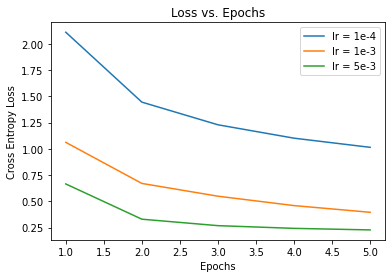

In [19]:
plt.title('Loss vs. Epochs')

plt.plot(range(1,6), history1['train loss'], label = 'lr = 1e-4')
plt.plot(range(1,6), history2['train loss'], label = 'lr = 1e-3')
plt.plot(range(1,6), history3['train loss'], label = 'lr = 5e-3')

plt.ylabel('Cross Entropy Loss')

plt.xlabel('Epochs')
plt.legend(loc=0)
plt.show()

## Implement Validation Inferencing

We will do validation testing at every epoch. We will go back to debugging on a manual training loop.

In [25]:
def single_softmax(x):
    exp_term = np.exp(x - np.max(x))
    return exp_term/np.sum(exp_term)

def single_crossentropy(y, y_hat):
    epsilon = 1e-4
    return -np.sum(y*np.log(y_hat + epsilon))/y.shape[0]

In [26]:
x_test, y_test = test_images, test_labels

In [30]:
# array of batch sizes
batch_arr = [(X[k:k+batch_size], y[k:k+batch_size]) for k in range(0, X.shape[0], batch_size)]

val_arr = [(x_val, y_val) for x_val, y_val in zip(x_test, y_test)]

num_vals = len(val_arr)

num_batches = len(batch_arr)

print(f'We have {num_batches} batches in our dataset.')

# 1. INITIALIZE WEIGHTS (weights unchanged, biases do change however)

w1 = np.random.randn(input_dim, hidden_dim)
b1 = np.random.randn(batch_size, hidden_dim)

# print(f'Shape of w1 is {w1.shape}, Shape of b1 is {b1.shape}')

w2 = np.random.randn(hidden_dim, output_dim)
b2 = np.random.randn(batch_size, output_dim)

# print(f'Shape of w2 is {w2.shape}, Shape of b2 is {b2.shape}')

epochs = 5

total_train_time = 0

# 2. FEEDFORWARD
for epoch in range(epochs):
    epoch_correct_classes = 0
    # initialize loss in our epoch
    loss_per_epoch = 0
    
    # start timer during beginning of epoch
    start_epoch = t.default_timer()
    
    for x_batch, y_batch in batch_arr:
        # first preactivation
        z1 = np.dot(x_batch, w1) + b1

        # first activation (relu)
        a1 = z1

        a1[a1 < 0] = 0

        # derivative of first activation

        da_1_dz_1 = np.where(a1 > 0, 1, 0)

        # second preactivation layer

        z2 = np.dot(a1, w2) + b2

        # second activation (apply softmax)

        y_hat = batch_softmax(z2)

        # 3. COMPUTE LOSS

        loss_arr = batch_crossentropy(y_batch, y_hat)

        loss_per_epoch += np.mean(loss_arr)

        # 4. BACKPROPAGATION

        dl_dz2 = y_hat - y_batch

        # TRICKY PART: since we now have every sample's vectors, we must do
        # a component-wise outer product of each vector
        # EACH "ROW" OF ARRAY CORRESPONDS TO A dl/dw2 for each input/label pair
        dl_dw2 = np.mean(component_wise_tensor(dl_dz2, a1), axis=0).T

        # THEN TAKE THE MEAN ACROSS AXIS 0 TO GET THE UPDATED WEIGHTS, and then tranpose

        dl_dz1 = np.dot(dl_dz2, w2.T) * da_1_dz_1

        # elementwise tensor product, then take the mean across the axis and transpose

        dl_dw1 = np.mean(component_wise_tensor(dl_dz1, x_batch), axis=0).T

        # get gradient of biases

        dl_db2, dl_db1 = dl_dz2, dl_dz1

        # 5. GRADIENT DESCENT

        w1, w2, b1, b2 = w1 - (lr/batch_size) * dl_dw1, w2 - (lr/batch_size) * dl_dw2, b1 - (lr/batch_size) * dl_db1, b2 - (lr/batch_size) * dl_db2
        
        # get classes from prediction
        batch_classes_predicted = np.argmax(y_hat, axis=1)
        
        # compare with y, count how many match in each batch
        epoch_correct_classes += (batch_classes_predicted == np.argmax(y_batch, axis=1)).sum()
    
    # implement validation testing
    val_loss_per_epoch = 0
    val_classes_predicted = 0
    for x_val, y_val in val_arr:
        # first preactivation
        val_z1 = np.dot(x_batch, w1) + b1

        # first activation (relu)
        val_a1 = val_z1

        val_a1[val_a1 < 0] = 0

        # derivative of first activation

        val_da_1_dz_1 = np.where(val_a1 > 0, 1, 0)

        # second preactivation layer

        val_z2 = np.dot(val_a1, w2) + b2

        # second activation (apply softmax)

        y_hat_val = single_softmax(val_z2)

        # 3. COMPUTE LOSS

        val_loss = single_crossentropy(y_batch, y_hat_val)

        val_loss_per_epoch += val_loss

        # 4. compute accuracy
        val_classes_predicted += (np.argmax(y_hat_val) == np.argmax(y_val)).sum()
    
    end_epoch = t.default_timer()
    total_train_time += end_epoch - start_epoch
    print(f'Epoch {epoch + 1} complete : Loss {loss_per_epoch/num_batches}: Training Accuracy {epoch_correct_classes/X.shape[0]} : Training Runtime {end_epoch - start_epoch} seconds\nValidation Loss {val_loss_per_epoch/num_vals} : Validation Accuracy {val_classes_predicted / num_vals}')

        # print(f'After one epoch, the size of w1 is {w1.shape}')
        # print(f'After one epoch, the size of w2 is {w2.shape}')
        # print(f'After one epoch, the size of b1 is {b1.shape}')
        # print(f'After one epoch, the size of b2 is {b2.shape}')
print(f'Total Training Time was {total_train_time} seconds')


We have 20000 batches in our dataset.
Epoch 1 complete : Loss 1.9573542003787618: Training Accuracy 0.31971666666666665 : Training Runtime 53.40881720000016 seconds
Validation Loss 9.210340371976212 : Validation Accuracy 0.1
Epoch 2 complete : Loss 1.3422505213286942: Training Accuracy 0.5120833333333333 : Training Runtime 43.69682789999979 seconds
Validation Loss 9.210340326486747 : Validation Accuracy 0.1


KeyboardInterrupt: 

Try implementing this in our class

In [38]:
# class simpleANN:
    
#     # artificial 1 hidden-layer neural network whose feedforward, backpropagation are all vectorized 
    
#     def __init__(self, input_dim, hidden_dim, output_dim, batch_size):
        
#         # initialize weights and biases
#         self.w1 = np.random.randn(input_dim, hidden_dim)
#         self.b1 = np.random.randn(batch_size, hidden_dim)
        
#         self.w2 = np.random.randn(hidden_dim, output_dim)
#         self.b2 = np.random.randn(batch_size, output_dim)
        
#         # initialize batch size as we will need to access this all throughout our code
#         self.batch_size = batch_size
        
#     def feedforward(self, x):
#         # feedforward: perform the feeding of the input up until the output layer
#         z1 = np.dot(x, self.w1) + self.b1

#         # first activation (relu)
#         # NOTE: normally, np.maximum(0, x) is the way to go, but since we are vectorizing, we must find a way to apply
#         # relu across the whole vector
#         a1 = z1

#         a1[a1 < 0] = 0

#         # derivative of first activation

#         da_1_dz_1 = np.where(a1 > 0, 1, 0)

#         # second preactivation layer

#         z2 = np.dot(a1, self.w2) + self.b2
        
#         return z1, a1, da_1_dz_1, z2
        
#     def predict(self, x, val=False):
#         # predict: this is the output layer, where we will be calling the softmax function
#         if not val:
#             return batch_softmax(x)
#         else:
#             return single_softmax(x)
        
#     def loss(self, y, y_hat, val=False):
#         # loss: computes the cross-entropy loss
#         if not val:
#             return batch_crossentropy(y, y_hat)
#         else:
#             return single_crossentropy(y, y_hat)
        
#     def backpropagate(self, x, y, y_hat, a1, da_1_dz_1):
#         # backpropagate: takes in x, y, y_hat, and the 2nd and 3rd outputs from feedforward
#         dl_dz2 = y_hat - y

#         # TRICKY PART: since we now have every sample's vectors, we must do
#         # a component-wise outer product of each vector
#         # EACH "ROW" (axis 0) OF ARRAY CORRESPONDS TO A dl/dw2 for each input/label pair
        
#         dl_dw2 = np.mean(component_wise_tensor(dl_dz2, a1), axis=0).T

#         # THEN TAKE THE MEAN ACROSS AXIS 0 TO GET THE UPDATED WEIGHTS, and then tranpose

#         dl_dz1 = np.dot(dl_dz2, self.w2.T) * da_1_dz_1

#         # elementwise tensor product, then take the mean across the axis and transpose

#         dl_dw1 = np.mean(component_wise_tensor(dl_dz1, x), axis=0).T

#         # get gradient of biases

#         dl_db2, dl_db1 = dl_dz2, dl_dz1
        
#         return dl_dw1, dl_dw2, dl_db1, dl_db2
    
#     def gradient_descent(self, grad_w1, grad_w2, grad_b1, grad_b2, lr=1e-4):
#         # gradient_descent: performs optimization of weights and biases
#         # NOTE: changes the weights/biases in place, so returns nothing
        
#         # eta is just a constant
#         eta = lr/self.batch_size
        
#         # actual GD steps
#         self.w1, self.w2, self.b1, self.b2 = self.w1 - (eta * grad_w1), self.w2 - (eta * grad_w2), self.b1 - (eta * grad_b1), self.b2 - (eta * grad_b2)
        
#         return
    
#     def fit(self, x, y, max_epochs=10, lr=1e-4, x_val=None, y_val=None):
#         # fit: performs training loop by calling feedforward, predict, loss, backpropagation, and gradient_descent
#         # NOTE: this training is done in batches, validation inferencing at the end of each epoch is optional
        
#         # array holding all batches of data
#         batch_arr = [(x[k:k+self.batch_size], y[k:k+self.batch_size]) for k in range(0, x.shape[0], self.batch_size)]
#         num_batches = len(batch_arr)
        
#         # count total train time
#         total_train_time = 0
        
#         # compile a history for metrics so we can plot performance later
#         history, li_trainloss, li_trainacc = dict(), [], []
        
#         # compile a history for validation
#         if x_val is not None and y_val is not None:
#             li_valloss, li_valacc = [], []
            
        
#         # training loop
#         for epoch in range(max_epochs):
#             epoch_correct_classes = 0
#             # initialize total loss in epoch
#             epoch_loss = 0
#             # call timer to roughly time how long each epoch took
#             start = t.default_timer()
#             for x_batch, y_batch in batch_arr:
#                 # 1. feedforward
#                 # obtains the parameters we need to plug into predict and backpropagate
                
#                 _, a1, da1_dz1, z2 = self.feedforward(x_batch)
                
#                 # 2. predict
#                 # gets the y_hat
                
#                 y_hat = self.predict(z2)
                
#                 # 3. get loss
#                 # gets an array of losses of size (batch_size,), corresponding to each input-label in the batch
                
#                 batch_loss = self.loss(y_batch, y_hat)
                
#                 # 4. backpropagate
#                 # obtains the gradients used in the gradient descent
                
#                 grad_w1, grad_w2, grad_b1, grad_b2 = self.backpropagate(x_batch, y_batch, y_hat, a1, da1_dz1)
                
#                 # 5. batch gradient descent
#                 # changes weights and biases inplace
                
#                 self.gradient_descent(grad_w1, grad_w2, grad_b1, grad_b2, lr)
                
#                 # 6. average the loss across this batch
#                 epoch_loss += np.mean(batch_loss)
                
#                 # 7. compare classes of y_hat to y_batch
#                 batch_predicted_classes = np.argmax(y_hat, axis=1)
                
#                 epoch_correct_classes += (batch_predicted_classes == np.argmax(y_batch, axis=1)).sum()

#             # if we have an x_val and y_val input, get validation accuracy and loss
#             if x_val is not None and y_val is not None:
#                 epoch_loss_val = 0
#                 epoch_val_classes_predicted = 0
#                 val_arr = [(x_, y_) for x_, y_ in zip(x_val, y_val)]
#                 num_vals = len(val_arr)
#                 for x_, y_ in val_arr:
#                     # 1. feedforward
#                     _, _, _, val_z2 = self.feedforward(x_)
                    
#                     # 2. get prediction output
#                     y_hat_val = self.predict(val_z2, val=True)
                    
#                     # 3. get loss
#                     val_loss = self.loss(y_, y_hat_val, val=True)
#                     epoch_loss_val += (val_loss)
                    
#                     # 4. get accuracies and losses
                    
#                     epoch_val_classes_predicted += (np.argmax(y_hat_val) == np.argmax(y_)).sum()
#                 li_valloss.append(epoch_loss_val/num_vals)
#                 li_valacc.append(epoch_val_classes_predicted/num_vals)
                
#             # stop timer after one epoch
#             stop = t.default_timer()
#             # get loss per sample per epoch (average across all batches)
#             epoch_loss /= num_batches
#             # put loss per epoch into history
#             li_trainloss.append(epoch_loss)
#             # put accuracy per epoch into history
#             li_trainacc.append(epoch_correct_classes/x.shape[0])
#             # get total time elapsed during training
#             epoch_time = stop - start
#             # get total time elapsed overall
#             total_train_time += epoch_time
            
#             # print output for training metrics
#             print(f'Epoch {epoch + 1} : Loss {li_trainloss[epoch]} : Training Accuracy {li_trainacc[epoch]*100:.4f}% : Training Runtime {epoch_time} Seconds\nValidation Loss {li_valloss[epoch]} : Validation Accuracy {li_valacc[epoch]*100:.4f}%')
        

                
#         # print output for total train time
#         print(f'Total Training Runtime {total_train_time} Seconds')
        
#         # put losses/accuracy into history
#         history['train loss'] = li_trainloss
#         history['train accuracy'] = li_trainacc
#         history['val loss'] = li_valloss
#         history['val accuracy'] = li_valacc
        
#         return history

In [39]:
# initialize neural network

ANN1_again = simpleANN(input_dim, hidden_dim, output_dim, batch_size)

In [40]:
history_w_val1 = ANN1_again.fit(X, y, max_epochs=5, lr=1e-4, x_val=x_test, y_val=y_test)

Epoch 1 : Loss 1.8724766462888103 : Training Accuracy 34.5533% : Training Runtime 59.93397660000028 Seconds
Validation Loss 1.9936143996601783 : Validation Accuracy 16.1200%
Epoch 2 : Loss 1.266359596950307 : Training Accuracy 53.6683% : Training Runtime 72.88406269999996 Seconds
Validation Loss 1.8499755780465958 : Validation Accuracy 18.5700%
Epoch 3 : Loss 1.0979582452039947 : Training Accuracy 59.1350% : Training Runtime 61.95224260000032 Seconds
Validation Loss 1.7743963360544712 : Validation Accuracy 19.8900%
Epoch 4 : Loss 0.9998106131438204 : Training Accuracy 62.1850% : Training Runtime 57.0467878999998 Seconds
Validation Loss 1.715395509386881 : Validation Accuracy 20.5900%
Epoch 5 : Loss 0.9309707995482671 : Training Accuracy 64.4000% : Training Runtime 57.28070109999953 Seconds
Validation Loss 1.664452859086782 : Validation Accuracy 21.0200%
Total Training Runtime 309.0977708999999 Seconds
